In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [89]:
reg_params = dict()
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes10000.npz'
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df$_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df7_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df4_degree3_genes1000.npz'
datafile = 'fits/shrunken_transformed_gene_regression_df4_degree3_genes1000_inflate1.0.npz'
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 30

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_fit'.format(
    df, degree, num_genes, num_components)

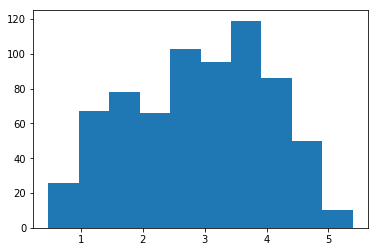

In [90]:
plt.hist(reg_params['y_info']);

In [92]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [93]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [94]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -8807.92137535
Iter 1: f = -9061.46020686
Iter 2: f = -9379.55184952
Iter 3: f = -9590.03703264
Iter 4: f = -9611.13603378
Iter 5: f = -9644.61196302
Iter 6: f = -9692.43849535
Iter 7: f = -9707.87810973
Iter 8: f = -9726.52816100
Iter 9: f = -9682.63698558
Iter 10: f = -9738.27577412
Iter 11: f = -9741.91139230
Iter 12: f = -9754.75631489
Iter 13: f = -9754.09832767
Iter 14: f = -9757.75304772
Iter 15: f = -9758.84885698
Iter 16: f = -9760.37952018
Iter 17: f = -9762.01449097
Iter 18: f = -9757.70255817
Iter 19: f = -9763.10931386
Iter 20: f = -9764.41049828
Iter 21: f = -9750.92212113
Iter 22: f = -9765.84761248
Iter 23: f = -9766.15074814
Iter 24: f = -9766.42864525
Iter 25: f = -9766.50489052
Iter 26: f = -9766.68957065
Iter 27: f = -9765.73751640
Iter 28: f = -9767.08739331
Iter 29: f = -9767.20550670
Iter 30: f = -9767.24687306
Iter 31: f = -9767.16463906
Iter 32: f = -9767.26009140
Iter 33: f = -9767.26800452
Iter 34: f = -9767.26885061
Iter 35: f = -9767.27418519
It

In [95]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [96]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape

((238, 238), (238,))

In [97]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -9767.30113644
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -9767.30113644
Iter 2: f = -9767.30114247
6.036281774868257e-06
Iter 3: f = -9767.30114247
Success.
  Running preconditioned optimization.
Iter 0: f = -9767.30114247
Iter 1: f = -9767.30114247
Iter 4: f = -9767.30114247
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Taking Newton step.
  Converging with small Newton step.
Optimization time: 99.19670534133911 seconds


In [98]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[  0.3282212    0.44226443   0.84998847   0.99985885   1.15718651
   1.21724309   1.43343911   1.94492835   1.99483623   3.53100075
   3.65205062   3.84914958   4.178956     6.05555735   6.29482758
   6.90939025   7.33403316   8.46040218   9.63639601  11.08685828
  15.69739271  28.38195521  31.10764483  31.90959039  33.7851427
  35.37504982  65.37323472  80.01290762 140.14439302 156.85610098]


In [99]:
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

There are 4 small clusters


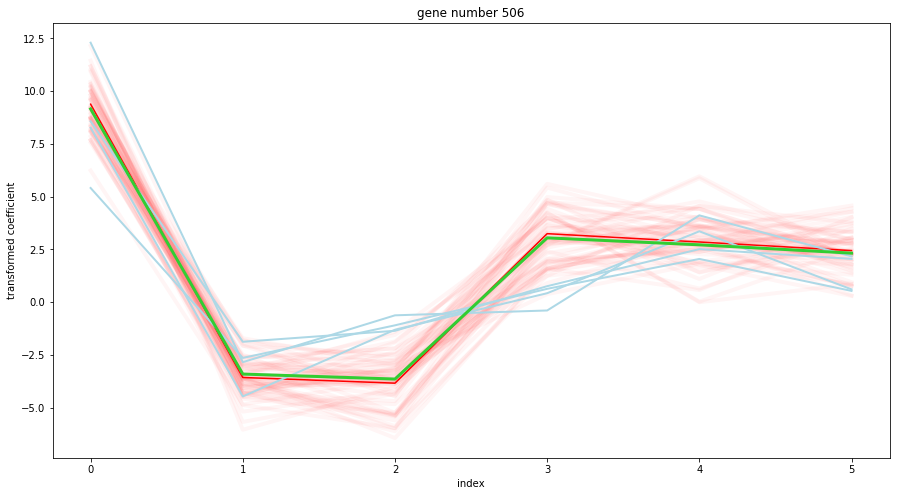

In [116]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))

small_cluster_size = 1.1

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < small_cluster_size))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
print('There are', len(small_clusters), 'small clusters')
k_small = 3
n_in_cluster = np.argwhere(obs_k == small_clusters[k_small])

if len(n_in_cluster) > 0:
    n = int(n_in_cluster[0])

    # Get the top alternative components
    top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[0:5]

    f, axarr = plt.subplots(1, figsize=(15,8))
    this_plot = axarr
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(60): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.04, linewidth=4);

    for k in top_components:
        if k != k_small:
            this_plot.plot(opt_gmm_params['centroids'][k, :],
                           color = 'lightblue', linewidth=2);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);
else:
    print('No points belong mostly to this cluster ({}).'.format(small_clusters[k_small]))


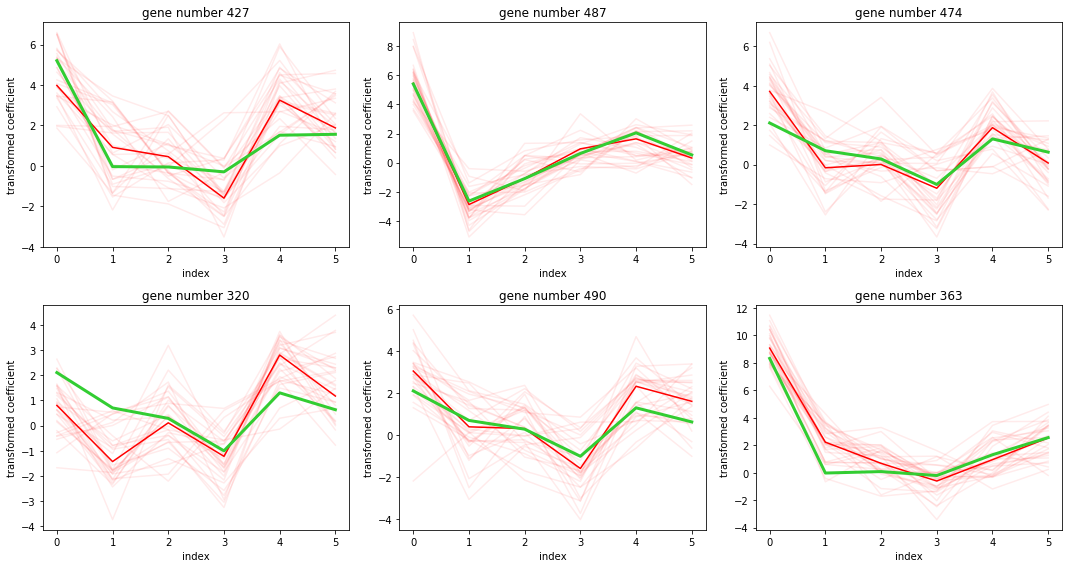

In [117]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [118]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df4_degree3_genes700_num_components30_fit.npz
